In [1]:
# Load

from pathlib import Path
import pandas as pd

PROJECT = Path.cwd()
PROCESSED = PROJECT / "data" / "processed"

clin = pd.read_csv(PROCESSED / "clinical_with_subtypes_k2.csv", index_col=0)
print(clin["subtype"].value_counts())


subtype
C1    54
C2    41
Name: count, dtype: int64


In [2]:
# Extract RFS time + event

time_col = "Recurrence-free survival, days"
event_col = "Recurrence status (1, yes; 0, no)"

df = clin[["subtype", time_col, event_col]].copy()
df["time"] = pd.to_numeric(df[time_col], errors="coerce")
df["event"] = pd.to_numeric(df[event_col], errors="coerce")

df = df.dropna(subset=["time", "event"])
df["event"] = df["event"].astype(int)

print("usable rows:", df.shape[0])
print(df.groupby("subtype")[["time","event"]].agg({"time":["count","median"], "event":"sum"}))


usable rows: 12
         time        event
        count median   sum
subtype                   
C1          6  515.5     6
C2          6  617.5     6


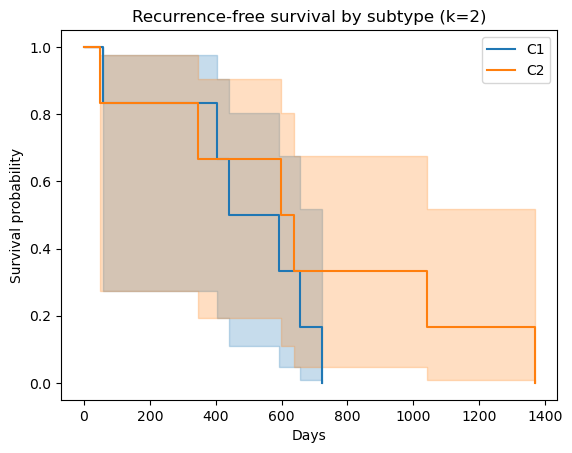

In [3]:
# KM plot

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

plt.figure()
for grp in sorted(df["subtype"].unique()):
    m = df["subtype"] == grp
    kmf = KaplanMeierFitter()
    kmf.fit(df.loc[m, "time"], event_observed=df.loc[m, "event"], label=grp)
    kmf.plot_survival_function()

plt.title("Recurrence-free survival by subtype (k=2)")
plt.xlabel("Days")
plt.ylabel("Survival probability")
plt.show()


In [4]:
# Log-rank p-value

from lifelines.statistics import logrank_test

g1, g2 = sorted(df["subtype"].unique())
d1 = df[df["subtype"] == g1]
d2 = df[df["subtype"] == g2]

res = logrank_test(d1["time"], d2["time"], event_observed_A=d1["event"], event_observed_B=d2["event"])
print("Log-rank p-value:", res.p_value)


Log-rank p-value: 0.367276993839163


In [5]:
cols_to_check = [
    "Overall survival, days",
    "Overall survival from collection, days",
    "Survival status (1, dead; 0, alive)",
    "Recurrence-free survival, days",
    "Recurrence-free survival from collection, days",
    "Recurrence status (1, yes; 0, no)",
    "follow_up_period",
    "vital_status_at_date_of_last_contact",
    "tumor_status_at_date_of_last_contact_or_death",
]

for c in cols_to_check:
    if c in clin.columns:
        non_missing = pd.to_numeric(clin[c], errors="coerce").notna().sum() if "status" not in c.lower() and "vital" not in c.lower() and "tumor_status" not in c.lower() else clin[c].notna().sum()
        print(f"{c}: non-missing = {non_missing}")
    else:
        print(f"{c}: NOT FOUND")


Overall survival, days: non-missing = 95
Overall survival from collection, days: non-missing = 94
Survival status (1, dead; 0, alive): non-missing = 95
Recurrence-free survival, days: non-missing = 12
Recurrence-free survival from collection, days: non-missing = 12
Recurrence status (1, yes; 0, no): non-missing = 95
follow_up_period: non-missing = 0
vital_status_at_date_of_last_contact: non-missing = 95
tumor_status_at_date_of_last_contact_or_death: non-missing = 95
